In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker 
import sys

In [2]:
#retrieving data from rider activity
path = sys.path[0]
df= pd.read_csv(path+'/Rider_activity.csv')
df

,date,schedule,deliveries,hrs,tips
0,2021-05-21,15.15-23.15,16,8.00,12.0
1,2021-05-22,15.15-23.15,20,8.00,24.0
2,2021-05-25,07.45-15.45,19,8.00,19.0
3,2021-05-28,15.15-23.15,16,8.00,19.9
4,2021-05-29,15.15-23.15,21,8.00,20.8
...,...,...,...,...,...
242,2022-08-20,17.18-22.15,21,4.95,20.5
243,2022-08-23,10.14-16.11,17,5.95,20.5
244,2022-08-24,10.24-16.15,23,5.85,21.7
245,2022-08-25,16.45-23.19,29,6.57,20.9


In [40]:
def barplot(diz,z):
    fig, ax = plt.subplots(figsize=(13,7)) 
    ax.bar(diz.keys(),diz.values(), color='darkblue',label=z)
    plt.title(z)
    plt.xticks(rotation=90)
    plt.legend()
    plt.show()

def plot(diz,z):
    fig, ax = plt.subplots(figsize=(13,7)) 
    ax.plot(diz.keys(),diz.values(), color='darkblue',label=z)
    plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f €'))
    plt.title(z)
    plt.xticks(rotation=90)
    plt.legend()
    plt.show()


In [4]:
#for each schedule we create a range of 1 minutes values within the schedule
l=[]
for el in df.schedule:
    start,end=el.split('-')
    start,end=start.replace(".",":"),end.replace(".",":")
    if end=='03:02': #because of bugged clock out

        l.append(pd.date_range(start, '23:15' , freq="1min").time)
        continue
    if end[:2]=='00': #if the clockout is after midnight we have to split in two parts otherwise the range won't work
        midnight=[]
        midnight=np.append(pd.date_range(start ,'23:59' , freq="1min").time, pd.date_range('00:00' ,end , freq="1min").time)
        l.append(midnight)
        continue
    l.append(pd.date_range(start, end, freq="1min").time)       
df['rangemin']=l
#we add a column to the dataframe of the 1min range of that schedule

Basically we look every 30 minutes from the beginning to the end of the day and we scan the whole dataframe.
If in those 30 mins we were working we sum up to the three dictionaries: counts,  tips and the deliveries done
Example: At '17.30' I was working for a total of 186 times. Considering all those 186 working days I was earning 3717€ of tips and I was doing 3023 deliveries. The avarage Tip/Delivery ratio at '17.30' is 1.22€/delivery.

In [32]:

def timegrouper():
    day=pd.date_range('00:00','23:59',freq='30min').strftime('%H:%M:%S') #we divide the day in 30 mins blocks
    counts,delhrs,tipdel={},{},{}
    for minute in day:
        s,counts[minute]=0,0
        deli,delhrs[minute]=0,0
        tips,tipdel[minute]=0,0
        hrs=0
        for i in range(len(df)):
            rangetime=df.rangemin.loc[i]
            row=[str(el) for el in rangetime]
            if minute in row: #if the working block coincides with the 30mins block of the day
                deli+=df.deliveries.loc[i]
                tips+=df.tips.loc[i]
                hrs+=df.hrs.loc[i]
                s+=1
                counts[minute]=s
                delhrs[minute]=deli/hrs
                tipdel[minute]=tips/deli
    return counts,delhrs,tipdel
counts,delhrs,tipdel=timegrouper()

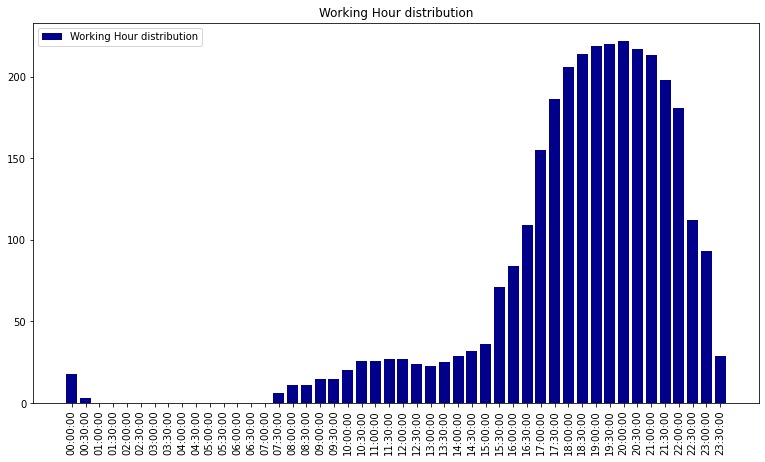

In [46]:
barplot(counts,'Working Hour distribution')

In [37]:
#We consider only the working blocks that have more than 50 counts
fdelhrs = {x: delhrs[x] for x in delhrs.keys() if x in pd.date_range('15:30','23:00',freq='30min').strftime('%H:%M:%S')}
ftipdel = {x: tipdel[x] for x in tipdel.keys() if x in pd.date_range('15:30','23:00',freq='30min').strftime('%H:%M:%S')}

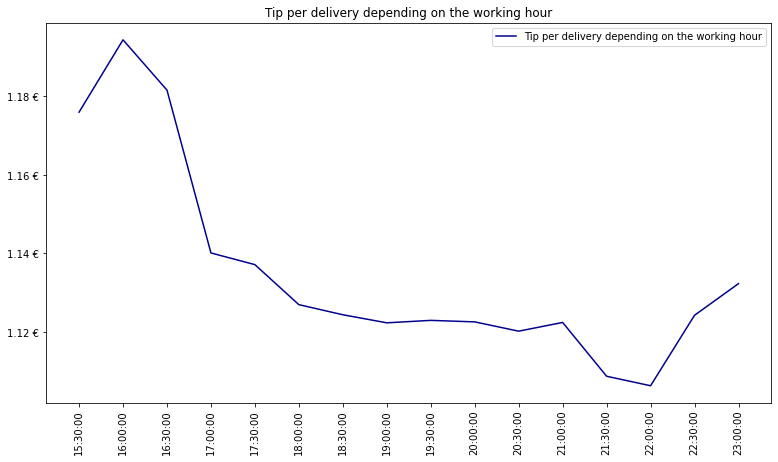

In [41]:
plot(ftipdel,'Tip per delivery depending on the working hour')

In [44]:
def plot(diz,z):
    fig, ax = plt.subplots(figsize=(13,7)) 
    ax.plot(diz.keys(),diz.values(), color='darkblue',label=z)
    plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f del/hr'))
    plt.title(z)
    plt.xticks(rotation=90)
    plt.legend()
    plt.show()


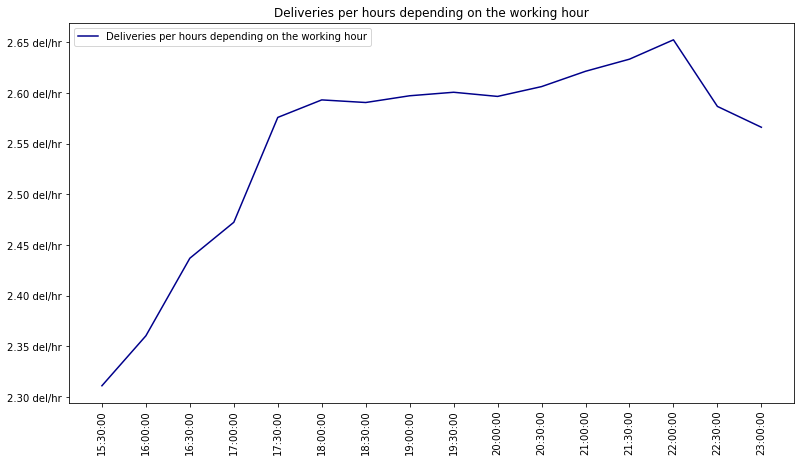

In [45]:
plot(fdelhrs,'Deliveries per hours depending on the working hour')